In [1]:
# import libraries we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC, Precision, Recall
import joblib
import numpy as np

/Users/hepplexi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Datasets

In [2]:
# Load the dataset
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')
pd.set_option('display.max_columns', None)

## Data Pre-Processing

### Imblanced piecahrt

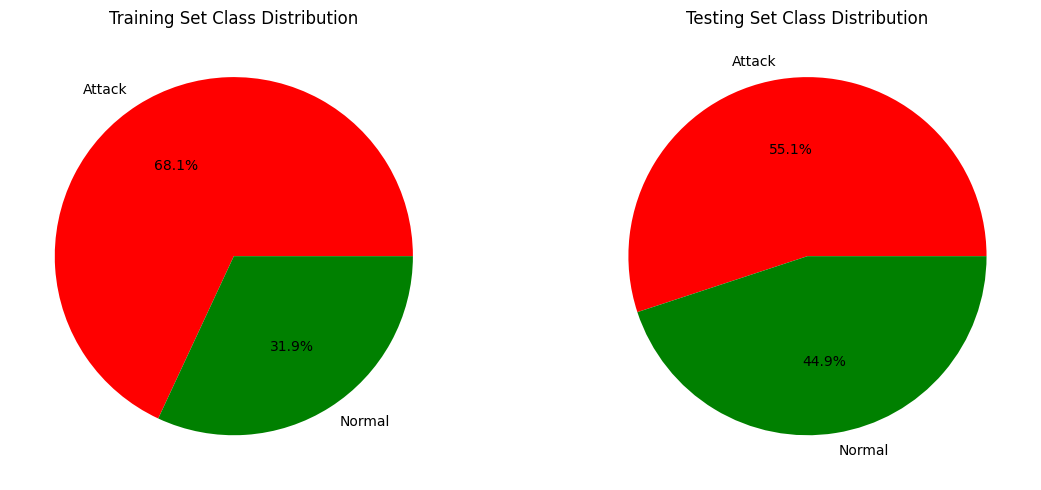

Training Set:
Total Samples: 175341
Normal Instances: 56000
Attack Instances: 119341

Testing Set:
Total Samples: 82332
Normal Instances: 37000
Attack Instances: 45332


In [3]:
# Count attacks and normal instances in training set
train_attack = len(df_train[df_train['label'] == 1])
train_normal = len(df_train[df_train['label'] == 0])

# Count attacks and normal instances in testing set
test_attack = len(df_test[df_test['label'] == 1])
test_normal = len(df_test[df_test['label'] == 0])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set pie chart
train_sizes = [train_attack, train_normal]
train_labels = ['Attack', 'Normal']
ax1.pie(train_sizes, labels=train_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax1.set_title('Training Set Class Distribution')

# Testing set pie chart
test_sizes = [test_attack, test_normal]
test_labels = ['Attack', 'Normal']
ax2.pie(test_sizes, labels=test_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax2.set_title('Testing Set Class Distribution')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print out the exact numbers for reference
print("Training Set:")
print(f"Total Samples: {len(df_train)}")
print(f"Normal Instances: {train_normal}")
print(f"Attack Instances: {train_attack}")

print("\nTesting Set:")
print(f"Total Samples: {len(df_test)}")
print(f"Normal Instances: {test_normal}")
print(f"Attack Instances: {test_attack}")

### NA Check

In [4]:
# NACheck
NACheck = df_train.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    175341.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [5]:
NACheck = df_test.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    82332.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

### Missing data:
There are **no missing values** in the dataset at all.

### Correlation Heatmap

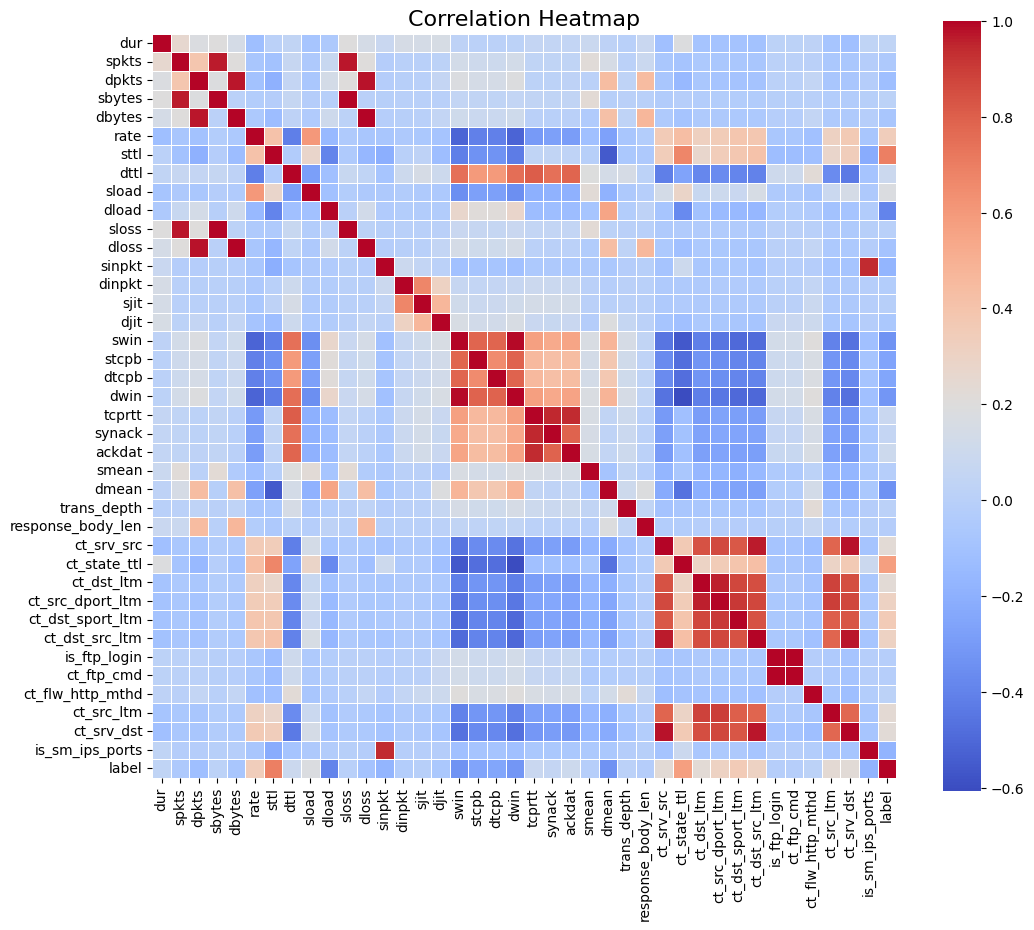

In [6]:
# Drop object/string columns
string_columns = df_train.select_dtypes(include=['object']).columns
df_train = df_train.drop(columns=string_columns)
df_train = df_train.drop('id', axis=1)
# Compute the correlation matrix
correlation_matrix = df_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

# Add title
plt.title("Correlation Heatmap", fontsize=16)

# Display the heatmap
plt.show()

### Feature Selection
Choose Which feature is useful for the Thread Detection using correlation and ANOVA

#### Correlation

In [7]:
# Compute Correlation with the target column 'label'
correlation = df_train.corrwith(df_train['label']).sort_values(ascending=False).to_frame()
correlation.columns = ['corr']  

# Select features with significant positive correlation (> 0.1)
PositiveCorrelation = correlation[correlation['corr'] > 0.1]

# Select features with significant negative correlation (< -0.1)
NegativeCorrelation = correlation[correlation['corr'] < -0.1]

# Combine positively and negatively correlated features
FeatureTemp = NegativeCorrelation.index.append(PositiveCorrelation.index)

# Create a subset of the DataFrame with these features
FilterSelectionColumn = df_train[FeatureTemp]  # Subset DataFrame with selected features
correlation

,corr
label,1.000000
sttl,0.692741
ct_state_ttl,0.577704
ct_dst_sport_ltm,0.357213
rate,0.337979
ct_src_dport_ltm,0.305579
ct_dst_src_ltm,0.303855
ct_src_ltm,0.238225
ct_dst_ltm,0.229887
ct_srv_src,0.229044


#### ANOVA

In [8]:
# Prepare features and target for ANOVA
features = df_train.drop('label', axis=1)  # Drop 'label' to isolate features
target = df_train['label']  # Target variable

# Use SelectKBest with ANOVA (f_classif) to score features
best_features = SelectKBest(score_func=f_classif, k='all')  # Evaluate all features
fit = best_features.fit(features, target)  # Fit the ANOVA model

# Store ANOVA scores in a DataFrame for easier interpretation
featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
featureScores

,ANOVA Score
dur,229.749327
spkts,478.672832
dpkts,2501.116244
sbytes,60.522430
dbytes,1042.259653
rate,22611.817828
sttl,161780.526952
dttl,1598.495322
sload,6066.435816
dload,32170.312851


#### Feature Selection
Select the features where both ANOVA and correlation significantly contribute to the classification process.

In [9]:
# Combine Correlation and ANOVA results
# Merge correlation and ANOVA scores into a single DataFrame
combined_scores = featureScores.merge(correlation, left_index=True, right_index=True)

# Filter features where both correlation and ANOVA score thresholds are satisfied
# (ANOVA Score > threshold, correlation > 0.1 or < -0.1)
anova_threshold = 2000  # Example threshold for ANOVA scores
selected_features = combined_scores[
    (combined_scores['corr'].abs() > 0.1) & (combined_scores['ANOVA Score'] > anova_threshold)
]

# Subset the original DataFrame with the selected features
final_selected_features = selected_features.index.tolist()  # Get the names of selected features
final_df = df_train[final_selected_features + ['label']]  # Include 'label' column for classification tasks

# Display the selected features and scores
print("Selected Features Based on Correlation and ANOVA:")
print(selected_features)

# Final filtered DataFrame for model training or evaluation
print("\nFinal DataFrame with Selected Features:")
final_df

Selected Features Based on Correlation and ANOVA:
                    ANOVA Score      corr
dpkts               2501.116244 -0.118591
rate               22611.817828  0.337979
sttl              161780.526952  0.692741
sload               6066.435816  0.182870
dload              32170.312851 -0.393739
sinpkt              5612.172675 -0.176110
swin               21961.796620 -0.333633
stcpb              12194.973688 -0.255006
dtcpb              11723.168274 -0.250340
dwin               19950.909669 -0.319626
dmean              23195.039749 -0.341806
ct_srv_src          9707.760648  0.229044
ct_state_ttl       87830.779493  0.577704
ct_dst_ltm          9783.377995  0.229887
ct_src_dport_ltm   18059.210546  0.305579
ct_dst_sport_ltm   25645.955324  0.357213
ct_dst_src_ltm     17835.399757  0.303855
ct_src_ltm         10549.386809  0.238225
ct_srv_dst          9618.746066  0.228046
is_sm_ips_ports     6191.368613 -0.184679

Final DataFrame with Selected Features:


,dpkts,rate,sttl,sload,dload,sinpkt,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,4,74.087490,252,1.415894e+04,8495.365234,24.295600,255,621772692,2202533631,255,43,1,0,1,1,1,1,1,1,0,0
1,38,78.473372,62,8.395112e+03,503571.312500,49.915000,255,1417884146,3077387971,255,1106,43,1,1,1,1,2,1,6,0,0
2,16,14.170161,62,1.572272e+03,60929.230470,231.875571,255,2116150707,2963114973,255,824,7,1,2,1,1,3,2,6,0,0
3,12,13.677108,62,2.740179e+03,3358.622070,152.876547,255,1107119177,1047442890,255,64,1,1,2,1,1,3,2,1,0,0
4,6,33.373826,254,8.561499e+03,3987.059814,47.750333,255,2436137549,1977154190,255,45,43,1,2,2,1,40,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,24,2,24,24,13,24,24,24,0,1
175337,8,33.612649,254,8.826286e+03,4903.492188,54.400111,255,3518776216,3453092386,255,44,1,1,1,1,1,2,1,1,0,1
175338,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,12,2,3,3,3,13,3,12,0,1
175339,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,30,2,30,30,14,30,30,30,0,1


## Modeling and Analysis

### Model Evaluation

In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions and probabilities
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred = model.predict(X_test)
        y_prob = model.decision_function(X_test)
    elif model_name == "Ensemble Model":
        y_prob = model.predict_proba(X_test)
        y_pred = model.predict(X_test)
    else:
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.3).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print metrics
    print(f"=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUROC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    auprc = average_precision_score(y_test, y_prob)     # Compute AUPRC
    plt.figure()
    plt.plot(recall_vals, precision_vals, label=f"PR curve (AUPRC = {auprc:.2f})")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right")
    plt.show()

### Load the data in the data

In [11]:
# Load the dataset
X_train = final_df.drop('label', axis=1)
y_train = final_df['label']
X_test = df_test[final_selected_features]
y_test = df_test['label']

### LogisticRegression

=== LogisticRegression ===
Accuracy: 0.7716
Recall: 0.9587
Precision: 0.7196
F1-Score: 0.8221
Sensitivity: 0.9587
Specificity: 0.5423

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.54      0.68     37000
           1       0.72      0.96      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.82      0.75      0.75     82332
weighted avg       0.81      0.77      0.76     82332



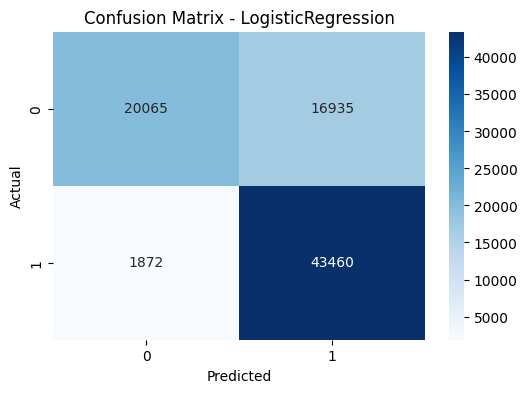

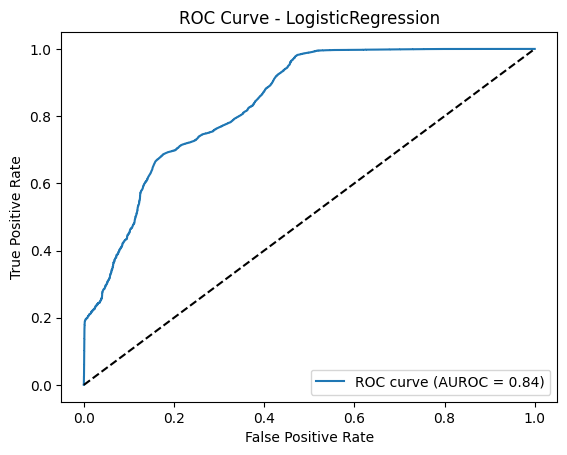

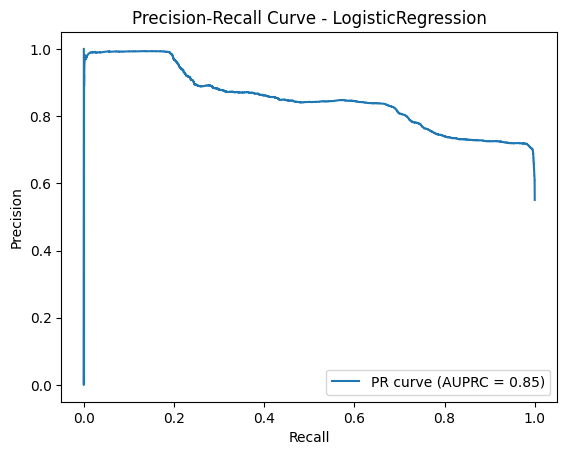

In [12]:
# Create a pipeline for scaling and training LinearSVC
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('lr', LogisticRegression(max_iter=1000))  # Logistic Regression model
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(lr_pipeline, X_test, y_test, "LogisticRegression")

### SVM(Support Vector Machines)

/Users/hepplexi/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== SVM ===
Accuracy: 0.7494
Recall: 0.8637
Precision: 0.7303
F1-Score: 0.7915
Sensitivity: 0.8637
Specificity: 0.6093

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.69     37000
           1       0.73      0.86      0.79     45332

    accuracy                           0.75     82332
   macro avg       0.76      0.74      0.74     82332
weighted avg       0.75      0.75      0.74     82332



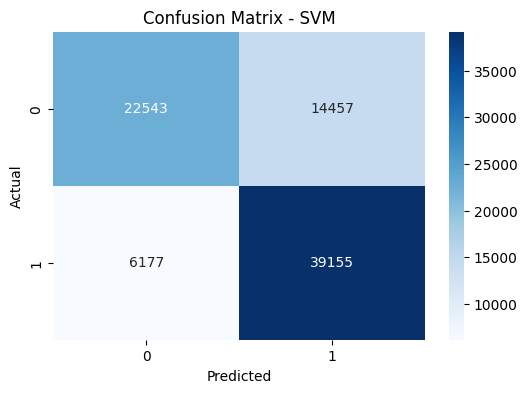

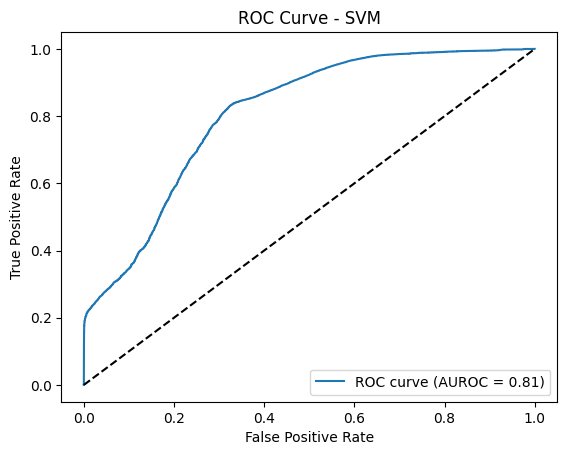

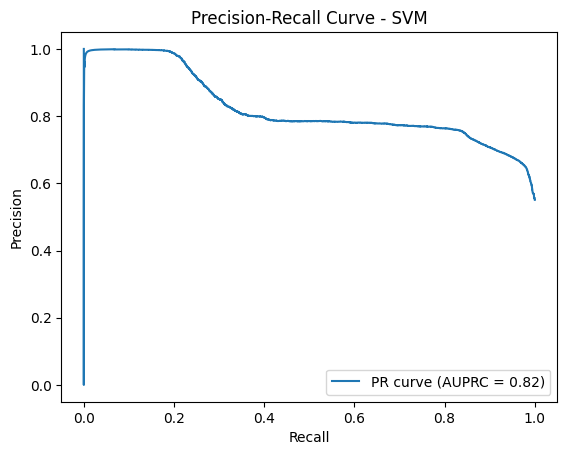

In [13]:
# Create a pipeline for scaling and training LinearSVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('svm', SVC(kernel="linear", class_weight="balanced", max_iter=10000))  # LinearSVC with balanced class weights
])

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(svm_pipeline, X_test, y_test, "SVM")

### Random Forest

=== Random Forest ===
Accuracy: 0.8620
Recall: 0.9859
Precision: 0.8066
F1-Score: 0.8873
Sensitivity: 0.9859
Specificity: 0.7103

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82     37000
           1       0.81      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.85     82332
weighted avg       0.88      0.86      0.86     82332



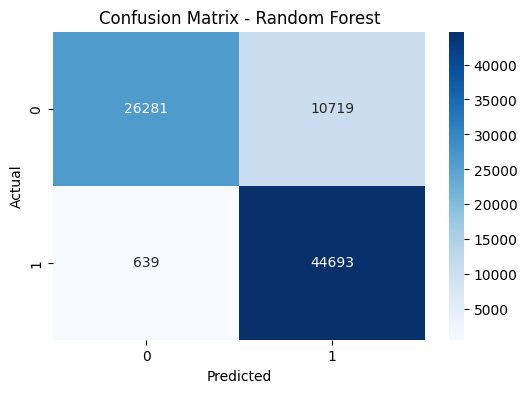

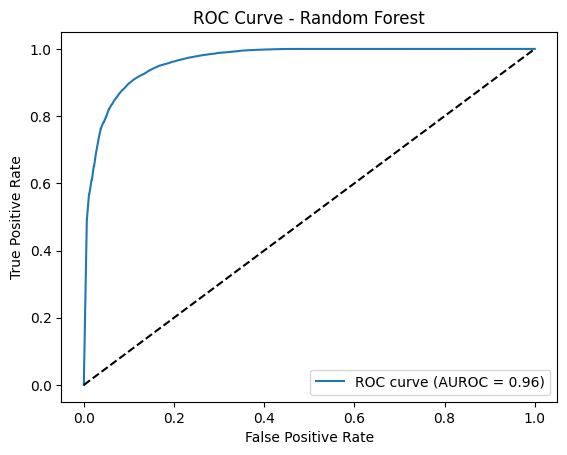

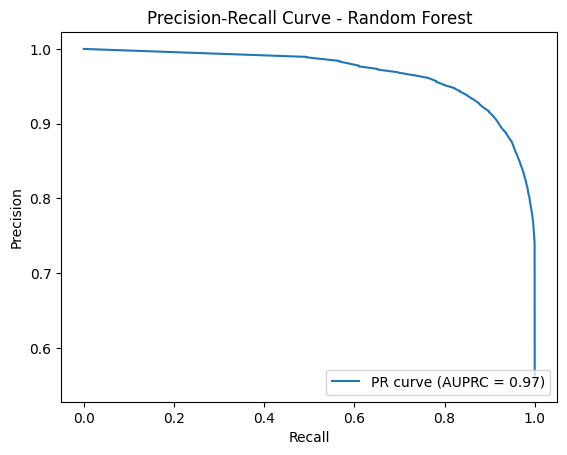

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=27)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

### XGBoost

=== XGBoost ===
Accuracy: 0.8962
Recall: 0.9628
Precision: 0.8643
F1-Score: 0.9109
Sensitivity: 0.9628
Specificity: 0.8147

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.88     37000
           1       0.86      0.96      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.89      0.89     82332
weighted avg       0.90      0.90      0.90     82332



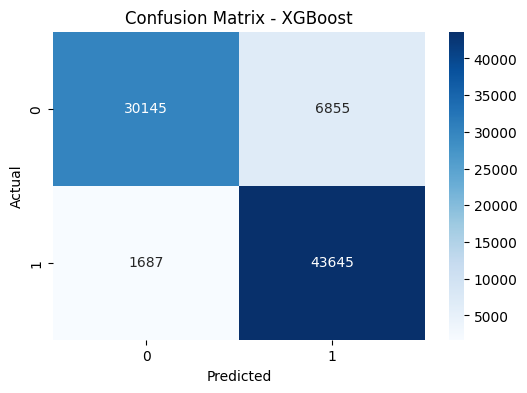

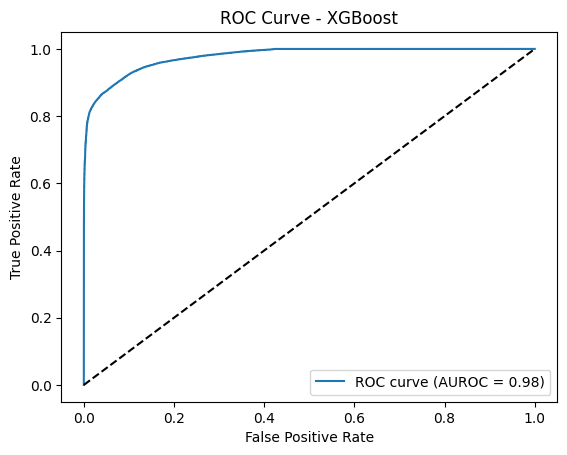

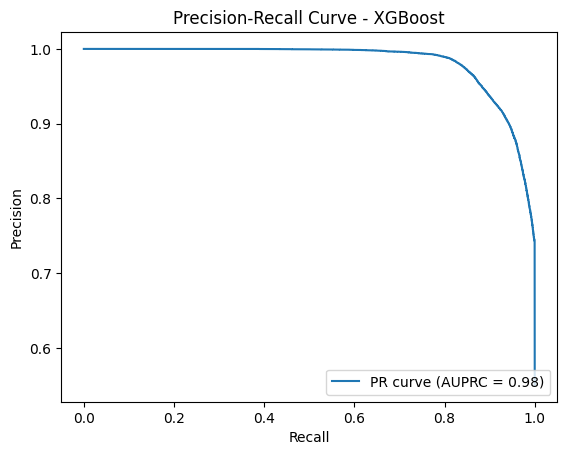

In [15]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=ratio,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=27,
    n_jobs=-1,
)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

### Neural Network(TensorFlow)

Epoch 1/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6693 - auc: 0.7606 - loss: 0.3834 - precision: 0.8250 - recall: 0.5775 - val_accuracy: 0.8677 - val_auc: 0.0000e+00 - val_loss: 0.2740 - val_precision: 1.0000 - val_recall: 0.8677
Epoch 2/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - auc: 0.8606 - loss: 0.3031 - precision: 0.8890 - recall: 0.6454 - val_accuracy: 0.8804 - val_auc: 0.0000e+00 - val_loss: 0.2830 - val_precision: 1.0000 - val_recall: 0.8804
Epoch 3/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - auc: 0.8791 - loss: 0.2868 - precision: 0.8874 - recall: 0.6975 - val_accuracy: 0.8954 - val_auc: 0.0000e+00 - val_loss: 0.2418 - val_precision: 1.0000 - val_recall: 0.8954
Epoch 4/200
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - auc: 0.8864 - loss: 0.2792 - precision: 0.8838 - recall: 0.7227 - val_accuracy: 0.8997 - val_auc: 0.0000e+00 - val_loss: 0.2395 - val_precision: 1.0000 - val_recall: 0.8997
Epoch 5/200


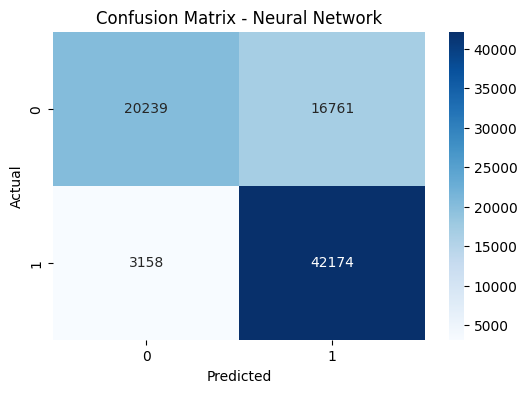

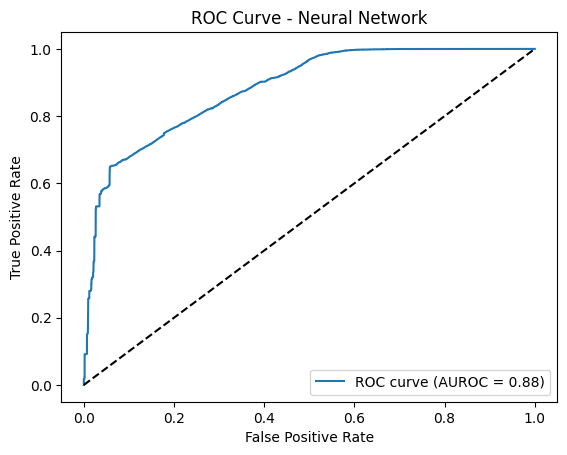

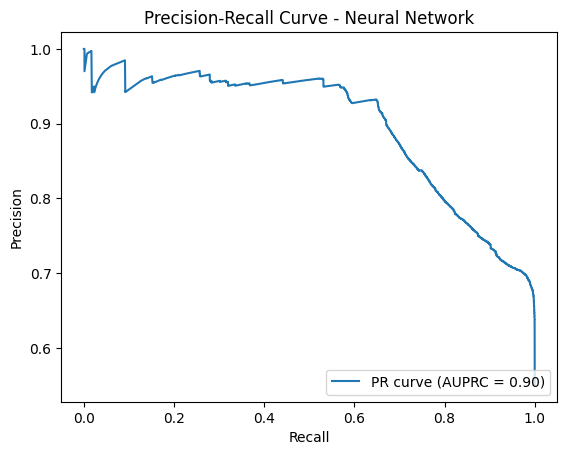

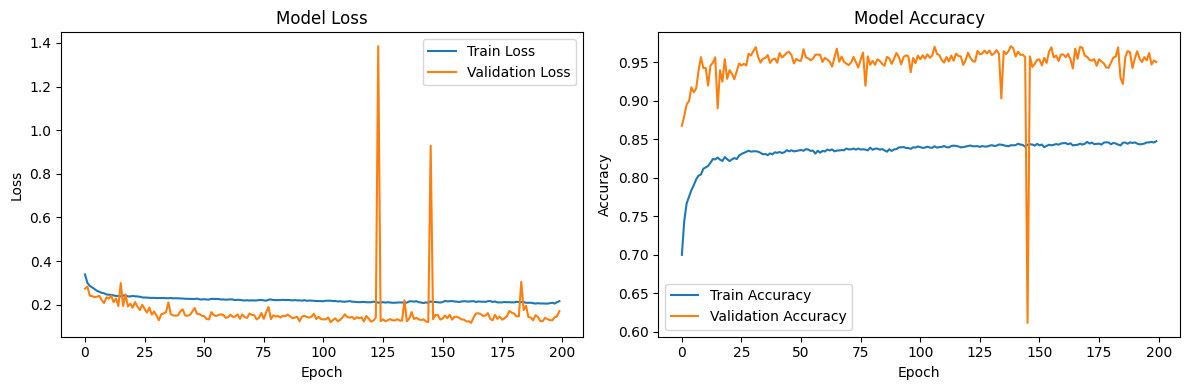

In [16]:
n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

tf_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),  # First Layer size
    BatchNormalization(),  # Add batch normalization
    Dropout(0.3),  # Add dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    # metrics=["accuracy"]
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

history = tf_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=200,  
    validation_split=0.2,
    class_weight=class_weight,
    verbose=1
)

evaluate_model(tf_model, X_test, y_test, "Neural Network")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Ensemble Model

=== Ensemble Model ===
Accuracy: 0.8547
Recall: 0.9460
Precision: 0.8184
F1-Score: 0.8776
Sensitivity: 0.9460
Specificity: 0.7429

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82     37000
           1       0.82      0.95      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.87      0.84      0.85     82332
weighted avg       0.86      0.85      0.85     82332



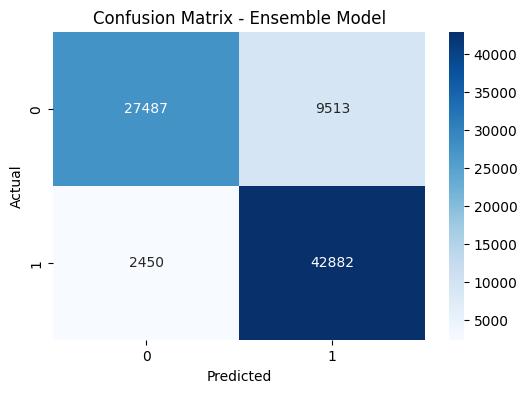

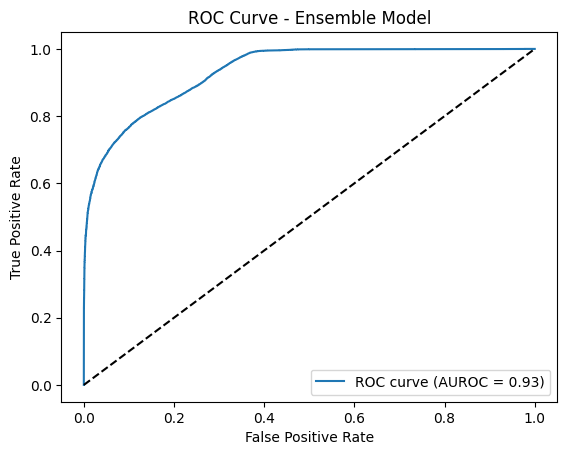

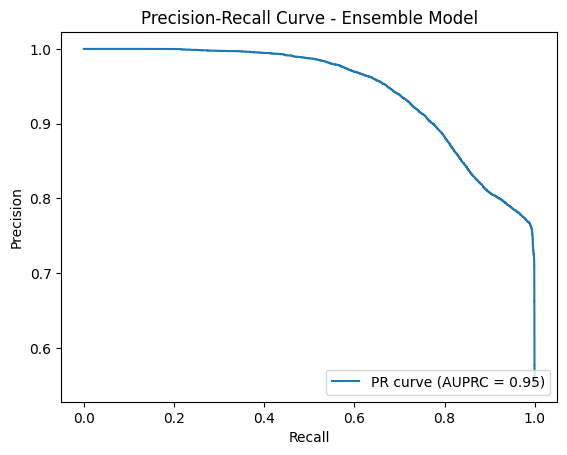

In [17]:
# Save 5 individual models
joblib.dump(lr_pipeline, "lr_pipeline.pkl")
joblib.dump(svm_pipeline, "svm_pipeline.pkl")
joblib.dump(rf_model,     "rf_model.pkl")
joblib.dump(xgb_model,    "xgb_model.pkl")
tf_model.save("nn_model.keras")          

# Majority‑vote ensemble model (needs ≥ 3 positives to label 1)
class MajorityVotingEnsemble:
    # Loads five saved models and predicts 1 (attack) only when at least 3 models vote for 1. 
    def __init__(
        self,
        lr_path="lr_pipeline.pkl",
        svm_path="svm_pipeline.pkl",
        rf_path="rf_model.pkl",
        xgb_path="xgb_model.pkl",
        nn_path="nn_model.keras",
        threshold=3,
    ):
        # load the four basic models
        self.lr  = joblib.load(lr_path)
        self.svm = joblib.load(svm_path)
        self.rf  = joblib.load(rf_path)
        self.xgb = joblib.load(xgb_path)

        # load the TensorFlow neural net
        self.nn  = tf.keras.models.load_model(nn_path)

        self.base_models = [self.lr, self.svm, self.rf, self.xgb]
        self.threshold   = threshold

    # Internal helper for the NN model
    def _nn_pred(self, X):
        # Return predictions from the NN model
        return (self.nn.predict(X, verbose=0).ravel() >= 0.3).astype(int)

    def _nn_proba(self, X):
        # Return probabilities from the NN model."""
        p1 = self.nn.predict(X, verbose=0).ravel()
        return np.column_stack([1 - p1, p1])

    def predict(self, X):
        preds = [m.predict(X) for m in self.base_models]   # 4 models
        preds.append(self._nn_pred(X))                     # +1 = 5
        votes = np.sum(preds, axis=0)                      # shape (n_samples,)
        return (votes >= self.threshold).astype(int)

    def predict_proba(self, X):
        probas = []
        for m in self.base_models:
            if hasattr(m, "predict_proba"):
                probas.append(m.predict_proba(X)[:, 1])
            else:  
                probas.append(m.decision_function(X))

        # NN probabilities
        probas.append(self._nn_proba(X)[:, 1])

        probas = np.stack(probas, axis=0)
        mean_p1 = probas.mean(axis=0)
        return np.column_stack([1 - mean_p1, mean_p1])
    
# Create an ensemble model
ensemble = MajorityVotingEnsemble(threshold=4)
# Evaluate
evaluate_model(ensemble, X_test, y_test, "Ensemble Model")